# Sales Forecasting 
The aim of this project is to predict sales using time series analysis and a regression model.

======================================================================================================

# Data Analysis
======================================================================================================

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from scipy.stats import skew, kurtosis

from feature_engine.encoding import CountFrequencyEncoder, OneHotEncoder

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# for plotting missing values
import missingno as msno


import pickle

In [2]:
# Set custom palette
colors = ['#0F7173', '#885A89', '#6A381F', '#F3DFA2', '#FCBF49', '#96E072']
sns.set_palette(sns.color_palette(colors))

# Load Stores data

In [3]:
stores = pd.read_csv('store.csv', index_col='Store')
stores

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


### Data fields
#### Features
* **Store:** a unique numerical Id for each store ("key" with sales data)
* **StoreType:** differentiates between 4 different store models (a, b, c, d)
* **Assortment :** describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance:** distance in meters to the nearest competitor store
* **CompetitionOpenSinceYear:** number of months since competition opened
* **Promo2:** it is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2SinceYear:**  describes the year when the store started participating in Promo2

In [4]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 1 to 1115
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StoreType                  1115 non-null   object 
 1   Assortment                 1115 non-null   object 
 2   CompetitionDistance        1112 non-null   float64
 3   CompetitionOpenSinceMonth  761 non-null    float64
 4   CompetitionOpenSinceYear   761 non-null    float64
 5   Promo2                     1115 non-null   int64  
 6   Promo2SinceWeek            571 non-null    float64
 7   Promo2SinceYear            571 non-null    float64
 8   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 87.1+ KB


## Missing values

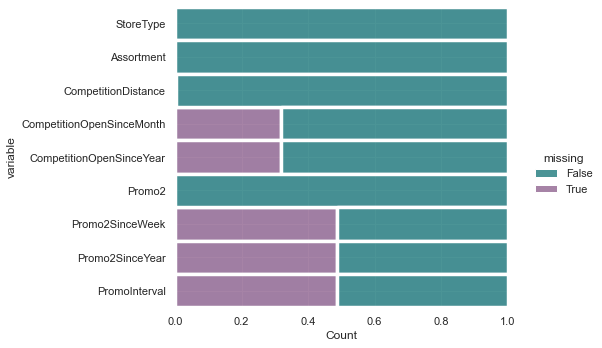

In [5]:
sns.displot(
           data = stores.isna().melt(value_name = 'missing'),
           y = 'variable',
           hue = 'missing',
           multiple = "fill",
           aspect = 1.5)
plt.show()

In [6]:
stores.isna().sum()

StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### Competition

In [7]:
stores[['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].describe()

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
count,1112.000000,761.000000,761.000000
mean,5404.901079,7.224704,2008.668857
std,7663.174720,3.212348,6.195983
min,20.000000,1.000000,1900.000000
25%,717.500000,4.000000,2006.000000
50%,2325.000000,8.000000,2010.000000
75%,6882.500000,10.000000,2013.000000
max,75860.000000,12.000000,2015.000000


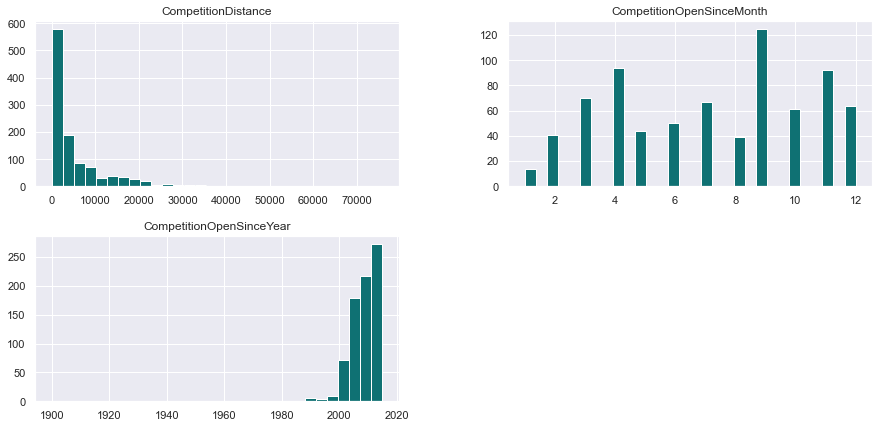

In [8]:
stores[['CompetitionDistance', 
        'CompetitionOpenSinceMonth', 
        'CompetitionOpenSinceYear']].hist(figsize = (15,7), bins = 30)
plt.show()

In [9]:
stores.CompetitionOpenSinceYear.value_counts()

2013.0    83
2012.0    82
2014.0    70
2005.0    62
2010.0    55
2011.0    54
2009.0    54
2008.0    54
2007.0    48
2006.0    47
2015.0    38
2002.0    27
2004.0    22
2003.0    19
2001.0    16
2000.0    10
1999.0     8
1990.0     5
1994.0     2
1995.0     2
1900.0     1
1961.0     1
1998.0     1
Name: CompetitionOpenSinceYear, dtype: int64

In [10]:
def fillna_competition(df):
    '''
    First, fill missing values when CompetitionDistance associated with "0" (no competitors)
    Then, fill remaining missing values with median (as data is skewed to the left, mean < median)
    Finally, fill missing values in CompetitionDistance with "1" (to be able to apply log transformation)
    '''
    
    df = df.copy()
    median_year = int(df.CompetitionOpenSinceYear.median())
    median_month = int(df.CompetitionOpenSinceMonth.median())
    
    
    # Filling with 0 if CompetitionDistance is missing 
    idx_comp_missing = df[df.CompetitionDistance.isna()].index
    df.CompetitionOpenSinceYear = [0 if i in idx_comp_missing else j for i, j in enumerate(df.CompetitionOpenSinceYear)]
    df.CompetitionOpenSinceMonth = [0 if i in idx_comp_missing else j for i, j in enumerate(df.CompetitionOpenSinceMonth)]
    
    
    # Filling remaining missing values with mean
    df.CompetitionOpenSinceYear = df.CompetitionOpenSinceYear.fillna(value = median_year).astype(np.int32)
    df.CompetitionOpenSinceMonth = df.CompetitionOpenSinceMonth.fillna(value = median_month).astype(np.int32)
        
    
    # Fill CompetitionDistance missing values
    df.CompetitionDistance = df.CompetitionDistance.fillna(value = 1)
    return df

In [11]:
stores = fillna_competition(stores)
stores.tail()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1111,a,a,1900.0,6,2014,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1112,c,c,1880.0,4,2006,0,NaN,NaN,NaN
1113,a,c,9260.0,8,2010,0,NaN,NaN,NaN
1114,a,c,870.0,8,2010,0,NaN,NaN,NaN
1115,d,c,5350.0,8,2010,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


### Promo2

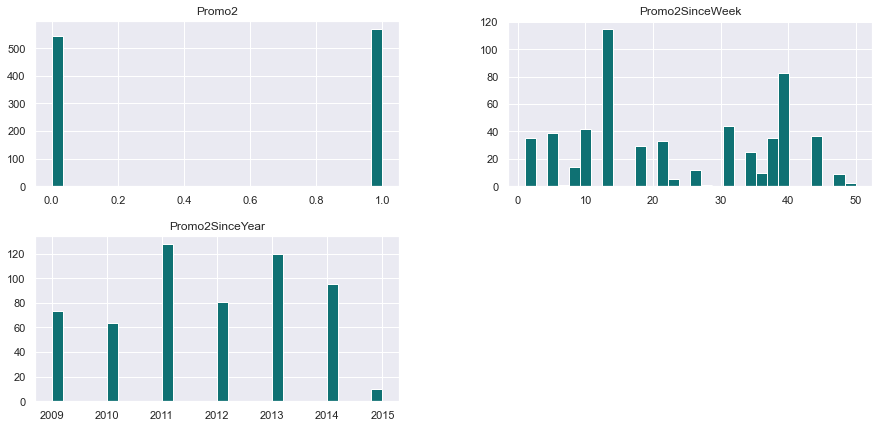

In [12]:
stores[['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear']].hist(figsize = (15,7), bins = 30)
plt.show()

In [13]:
# Checking number of stores participating or not in Promo2
stores.Promo2.value_counts()

1    571
0    544
Name: Promo2, dtype: int64

It would seem that the missing values in Promo2 related features are missing because those stores are simply not participating in the promotion, thus there are no values to report.

Hence, we can fill their missing values with "0".

In [14]:
stores.Promo2SinceYear = stores.Promo2SinceYear.fillna(value = 0).astype(np.int32)
stores.Promo2SinceWeek = stores.Promo2SinceWeek.fillna(value = 0).astype(np.int32)
stores.head()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270.0,9,2008,0,0,0,NaN
2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
3,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
4,c,c,620.0,9,2009,0,0,0,NaN
5,a,a,29910.0,4,2015,0,0,0,NaN


### Checking categorical variables

In [15]:
stores.StoreType.value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [16]:
stores.Assortment.value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [17]:
stores.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [18]:
# First cast categorical features (storetype & assortment)
# There is no data about the different store types, but their frequency may indicate some meaning about what they could be
# Thus, we can encode them by frequency

enc = CountFrequencyEncoder(variables='StoreType')
enc.fit(stores)
stores = enc.transform(stores)
stores.head()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,148,a,1270.0,9,2008,0,0,0,NaN
2,602,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
3,602,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
4,148,c,620.0,9,2009,0,0,0,NaN
5,602,a,29910.0,4,2015,0,0,0,NaN


In [19]:
# Concerning "Assortment", we know what that means, so we can first cast "a,b,c" to "basic, extra, extended"
# Then One-Hot-Encode the categorical variable
assort_dict = {'a': 'basic',
               'b': 'extra',
               'c': 'extended'}

stores.Assortment = stores.Assortment.replace(assort_dict)

In [20]:
stores.PromoInterval = stores.PromoInterval.fillna(value = 0)

In [21]:
ohe = OneHotEncoder(variables=['Assortment', 'PromoInterval'])
ohe.fit(stores)
stores = ohe.transform(stores)
stores.head()

,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Assortment_basic,Assortment_extended,Assortment_extra,PromoInterval_0,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec"
Store,,,,,,,,,,,,,,
1,148,1270.0,9,2008,0,0,0,1,0,0,1,0,0,0
2,602,570.0,11,2007,1,13,2010,1,0,0,0,1,0,0
3,602,14130.0,12,2006,1,14,2011,1,0,0,0,1,0,0
4,148,620.0,9,2009,0,0,0,0,1,0,1,0,0,0
5,602,29910.0,4,2015,0,0,0,1,0,0,1,0,0,0


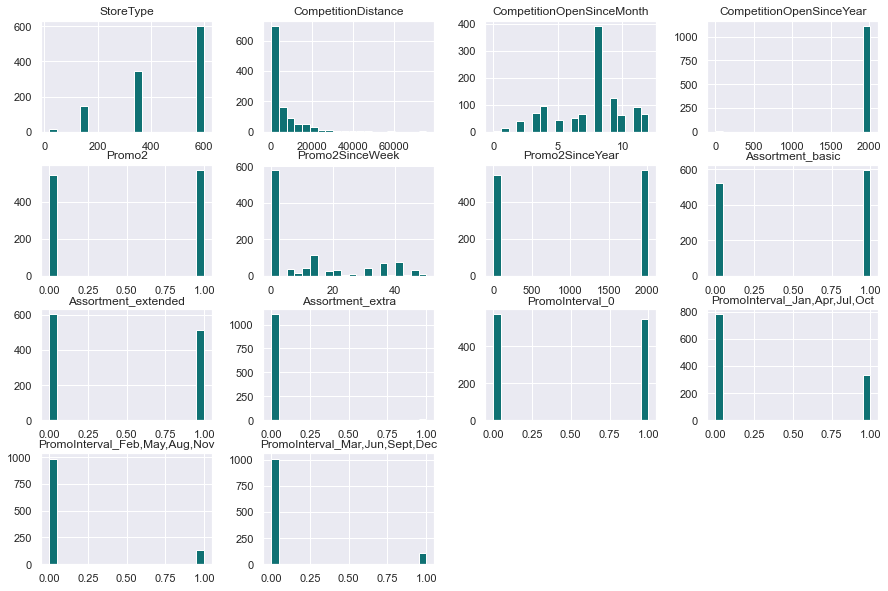

In [22]:
stores.hist(figsize = (15,10), bins = 20)
plt.show()

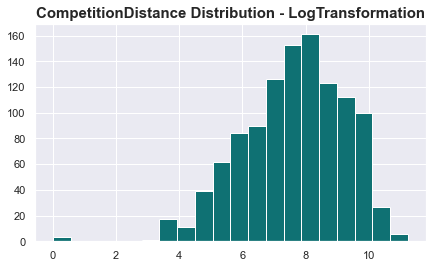

In [23]:
np.log(stores['CompetitionDistance']).hist(figsize = (7,4), bins = 20)
plt.title('CompetitionDistance Distribution - LogTransformation', weight = 'bold', size = 15)
plt.show()

In [24]:
stores['CompetitionDistance'] = np.log(stores['CompetitionDistance'])

In [25]:
stores.isna().sum()

StoreType                         0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
Assortment_basic                  0
Assortment_extended               0
Assortment_extra                  0
PromoInterval_0                   0
PromoInterval_Jan,Apr,Jul,Oct     0
PromoInterval_Feb,May,Aug,Nov     0
PromoInterval_Mar,Jun,Sept,Dec    0
dtype: int64

# External data on states

In [26]:
# https://www.kaggle.com/c/rossmann-store-sales/discussion/17048
states = pd.read_csv('store_states.csv')
states

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN
...,...,...
1110,1111,NW
1111,1112,NW
1112,1113,SH
1113,1114,HH


In [27]:
state_stats = pd.read_csv('state_stats.csv')
state_stats

,StateName,Area,Population,Density,State,GDP
0,Baden-Württemberg,35752,10755000,301,BW,34885
1,Bavaria,70552,12542000,178,BY,35443
2,Berlin,892,3469000,3890,BE,28806
3,Brandenburg,29479,2500000,85,BB,22074
4,Bremen,419,661000,1577,HB,42405
5,Hamburg,755,1788000,2368,HH,52401
6,Hesse,21115,6066000,287,HE,37509
7,Lower Saxony,47609,7914000,166,NI,28350
8,Mecklenburg-Vorpommern,23180,1639000,71,MV,21404
9,North Rhine-Westphalia,34085,17837000,523,NW,32882


In [28]:
state_stats[state_stats[['State']].isin(['HB', 'NI'])].stack()

4  State    HB
7  State    NI
dtype: object

In [29]:
state_gdp = {key:value for (key,value) in state_stats[['State', 'GDP']].values}
state_gdp['HB,NI'] = state_stats.iloc[4].GDP + state_stats.iloc[7].GDP
states['StateGDP'] = [state_gdp.get(f'{st}') for st in states.State]
states

In [31]:
state_density = {key:value for (key,value) in state_stats[['State', 'Density']].values}
state_density['HB,NI'] = state_stats.iloc[4].Density + state_stats.iloc[7].Density
states['StateDensity'] = [state_density.get(f'{st}') for st in states.State]
states

,Store,State,StateGDP,StateDensity
0,1,HE,37509,287
1,2,TH,21663,138
2,3,NW,32882,523
3,4,BE,28806,3890
4,5,SN,22980,227
...,...,...,...,...
1110,1111,NW,32882,523
1111,1112,NW,32882,523
1112,1113,SH,25947,179
1113,1114,HH,52401,2368


In [32]:
stores = stores.merge(states[['StateGDP', 'StateDensity', 'Store']], on = 'Store')

## Export train data

In [33]:
stores.isna().sum()

Store                             0
StoreType                         0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
Assortment_basic                  0
Assortment_extended               0
Assortment_extra                  0
PromoInterval_0                   0
PromoInterval_Jan,Apr,Jul,Oct     0
PromoInterval_Feb,May,Aug,Nov     0
PromoInterval_Mar,Jun,Sept,Dec    0
StateGDP                          0
StateDensity                      0
dtype: int64

In [34]:
stores.head()

,Store,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Assortment_basic,Assortment_extended,Assortment_extra,PromoInterval_0,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",StateGDP,StateDensity
0,1,148,7.146772,9,2008,0,0,0,1,0,0,1,0,0,0,37509,287
1,2,602,6.345636,11,2007,1,13,2010,1,0,0,0,1,0,0,21663,138
2,3,602,9.556055,12,2006,1,14,2011,1,0,0,0,1,0,0,32882,523
3,4,148,6.429719,9,2009,0,0,0,0,1,0,1,0,0,0,28806,3890
4,5,602,10.305948,4,2015,0,0,0,1,0,0,1,0,0,0,22980,227


In [35]:
stores.to_csv('stores_data.csv', index = False)